In [1]:
from sympy import *
interactive.printing.init_printing(use_latex=True)
from sympy.physics.vector import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import axes3d
warnings.simplefilter('ignore')
import multiprocessing as mp

# for vector operations
N = ReferenceFrame('N')

In [10]:
### dog cone properties ### 

rf = 0.075 # radius of quarz fiber/rod
rc = 0.09 # small radius of dog cone
RC = 0.2066726188957803 # big radius of dog cone
a = 3*pi/8 # angle of the cone
lc = ((2*rf + rc - rf)*sin(pi/4)/sin(a-pi/4)).evalf() # length of the cone (straight line along the surface)
hc = (lc*sin(a)).evalf() # height of the cone itself
cone_grid = np.zeros((5,25)) # boolean grid (0=False,1=True). Specifies whether rod 'm,k' has a dog cone.
for i in range(cone_grid.shape[1]): 
    cone_grid[:,i] = (i+1)%2 # even places get dog cone, odd don't

### general properties of the system ###

xb = 4.89/2 # base limits are (-xb,xb)x(-yb,yb) [cm], it's located on z=0 plane
yb = 4.64/2 # this bounds but doesn't determine the rod grid. This never shows up again in the code.
xp = 0.50 # PMT limits are (-xp,xp)x(-yp,yp) [cm], located on z=h plane
yp = 0.58 # this data is accurately taken from the ZDC solidworks assembly
h = 7
p_absorb = 0.1 # this is the probability for a photon to get absorbed in the metal instead of reflecting

### properties of the light sources (rods)

x0 = 1.4 # furthest chamber from the symmetry axis (along beam axis)
y0 = 2.16 # furthest rod from the symmetry axis (along chamber axis)
x_source = np.linspace(-x0,x0,5) # 5 chambers along the (real) beam axis, roughly spaced 0.7[cm] apart.
y_source = np.linspace(-y0,y0,25) # 25 rods per chamber, roughly spaced 0.18[cm] apart (minimal spacing is 0.15[cm] corresponding to the rod diameter)
source_grid = np.meshgrid(x_source,y_source) # the rod 'm,k' will be located at x=grid[0][k,m] and y=grid[1][k,m]
offset_grid = cone_grid * 0.5 # the rod 'm,k' will be located at z=offset_grid[m,k] (dog cone should be higher).

### winston cone
m = -0.5*(xp**2+yp**2)**(-0.5) # this is a paraboloid focused at (0,0,h)- the only one to pass through (xp,yp,h)
winston_cone = m*(N[0]**2 + N[1]**2) + h - 1/(4*m) # this should be a protected variable!!!

In [5]:
def Ray_Generator_ZDC():
    # Chooses a fiber/rod in random, from a defined grid
    np.random.seed()
    nx = np.random.randint(0,source_grid[0].shape[1])
    ny = np.random.randint(0,source_grid[0].shape[0])
    xc = source_grid[0][ny,nx]
    yc = source_grid[1][ny,nx]
    zc = offset_grid[nx,ny]

    # The ray is generated from a random point on the circular base surface of the rod (radius rf)
    rand_arg = np.random.uniform(-np.pi,np.pi)
    rand_rad = np.random.uniform(0,rf)
    xs = xc + rand_rad * np.cos(rand_arg)
    ys = yc + rand_rad * np.sin(rand_arg)
    pc = xc * N.x + yc * N.y + zc * N.z
    ps = xs * N.x + ys * N.y + zc * N.z
    
    # Chooses random orientation for the ray, polar angle distributed normally around 45 degrees. Narrow width.
    theta = np.random.normal(np.pi/4,np.pi/12)
    phi = np.random.uniform(-np.pi,np.pi)
    es = np.cos(phi)*np.sin(theta) * N.x + np.sin(phi)*np.sin(theta) * N.y + np.cos(theta) * N.z 
    
    # Returns a point 'ps' and a unit vector 'es', which characterize a straight line (the light ray before reflection).
    # returns tuplet (nx,ny)
    return ps,es,(nx,ny)

def Ray_Generator_Parallel():
    ### mostly for sanity checks
    np.random.seed()
    xs = np.random.uniform(-x0,x0)
    ys = np.random.uniform(-y0,y0)
    
    ps = xs*N.x + ys*N.y
    es = 1*N.z
    return ps,es

ray_x = lambda z,p,e: (p & N.x)+(e & N.x)/(e & N.z)*(z-(p & N.z))
ray_y = lambda z,p,e: (p & N.y)+(e & N.y)/(e & N.z)*(z-(p & N.z))

def Intersection(surface,p,e,bottom,top):
    # takes in the equation of the reflector surface
    # and also a point and a vector, describing a light ray traveling along a straight line
    if ((e & N.z) == 0):
        g = symbols('gamma',positive=True , real=True)
        xi = (p & N.x) + g * float(e & N.x)
        yi = (p & N.y) + g * float(e & N.y)
        zi = (p & N.z) + g * float(e & N.z)
        g_arr = np.array(solve(surface.subs([(N[0],xi),(N[1],yi)]),g,check=False)) # we will only get one solution
        xi = xi.subs(g,float(g_arr[0]))
        yi = yi.subs(g,float(g_arr[0]))
        return xi * N.x + yi * N.y
    else:
        x_z = (p & N.x) + (N[2] - (p & N.z))*(e & N.x)/(e & N.z)
        y_z = (p & N.y) + (N[2] - (p & N.z))*(e & N.y)/(e & N.z)
        surface = surface.subs([(N[0],x_z),(N[1],y_z)])
        sol = symbols('chi', positive=True, real=True) # this is needed because sympy doesn't handle radical equation very well
        surface = simplify(surface.subs(N[2],sol))
        sol_arr = np.array(solve(sol - surface,sol)) ## solve for intersection z
    for i in range(len(sol_arr)):
        if sol_arr[i].is_real:
            zi = float(sol_arr[i])
            if bottom <= zi <= top : ## if the ray intersects the boundary inside the light guide, we return the intersection
                return x_z.subs(N[2],zi) * N.x + y_z.subs(N[2],zi) * N.y + zi * N.z
    return 0 * N.x + 0* N.y ## otherwise, we return (0,0,0) and thus know it doesn't reflect off of the boundary

def Bisection(fc,p,e,height):
    # same purpose as 'Intersection'
    # uses a numerical method for solving, instead of analytical
    g = symbols('gamma',positive=True,real=True)
    xi = (p & N.x) + g * (e & N.x) # this is the parametric representation of the light ray straight line
    yi = (p & N.y) + g * (e & N.y)
    zi = (p & N.z) + g * (e & N.z)
    eq = fc.subs([(N[0],xi),(N[1],yi),(N[2],zi)]) # we substitute for the intersection equation
    
    gl = 0 # we choose a very big bracket
    gr = 2*height
    
    index = 1
    gc = (gl + gr)/2
    cc = float(eq.subs(g,gc).evalf())
    while (index <= 20 and np.allclose(cc,0,atol=1e-3)==False):
        index += 1
        cl = float(eq.subs(g,gl).evalf())
        cr = float(eq.subs(g,gr).evalf())
        if (cl * cc <= 0): # move right side to maintain bracket
            gr = gc
        elif (cr * cc <= 0): # move left side to maintain bracket
            gl = gc
        else: # if there's no bracket, there's no root inside (in our case) and thus no intersection
            return 0 * N.x + 0* N.y # so we return (0,0), ergo no reflection.
        gc = (gl + gr)/2
        cc = float(eq.subs(g,gc).evalf())
    
    if (np.allclose(cc,0,atol=0.005)):
        return xi.subs(g,gc)*N.x + yi.subs(g,gc)*N.y + zi.subs(g,gc)*N.z
    else:
        return 0 * N.x + 0* N.y 


def Dog_Cone(ps,es,tup):
    # checkes if a ray coming out of a rod is deflected by the cone
    # if yes, returns the deflected ray. if no- returns same ray.
    nx,ny = tup
    xc = source_grid[0][ny,nx]
    yc = source_grid[1][ny,nx]
    zc = offset_grid[nx,ny]
    
    cone = (tan(a)*(((N[0]-xc)**2 + (N[1]-yc)**2)**0.5 - rc)).evalf() + zc
    intersect = Bisection(N[2]-cone,ps,es,zc+hc)
    if intersect == 0*N.x + 0*N.y:
        return ps,es
    else:
        ps = intersect
        ns = Grad_Vec(N[2]-cone,ps)
        es = Ref_Vec(es,ns)
        return ps,es
    
def Normal_Vec(surface,intersect):
    # Finds the normal vectors to the surface fc at point of intersection.
    # first we look at the cylindrical coordinate parametrization of surface
    rho, phi = symbols('rho phi')
    xs = rho * cos(phi)
    ys = rho * sin(phi)
    surface = simplify(surface.subs([(N[0],xs),(N[1],ys)])) # this is z(rho,phi)
    t1 = diff(xs,rho) * N.x + diff(ys,rho) * N.y + diff(surface,rho) * N.z # tangent 1 
    t2 = diff(xs,phi) * N.x + diff(ys,phi) * N.y + diff(surface,phi) * N.z # tangent 2
    n_vec = (t2 ^ t1)# cross product
    xi = float(intersect & N.x)
    yi = float(intersect & N.y)
    arg = np.arctan2(yi,xi)
    n_vec = n_vec.subs([(rho,np.sqrt(xi**2 + yi**2)) ,(phi,arg)])
    return n_vec.normalize()

def Grad_Vec(surface,intersect):
    # Takes a surface which is a LEVEL SET: f(x,y,z) = 0
    # Returns the gradient at the intersection points, which is exactly the normal vector at that point.
    xi = float(intersect & N.x)
    yi = float(intersect & N.y)
    zi = float(intersect & N.z)
    gx = diff(surface,N[0])
    gy = diff(surface,N[1])
    gz = diff(surface,N[2])
    n_vec = gx * N.x + gy * N.y + gz* N.z
    n_vec = n_vec.subs([(N[0],xi),(N[1],yi),(N[2],zi)]).evalf()
    return n_vec.normalize()

def Ref_Vec(e,n):
    # Calculates the reflected ray unit vector, by the reflection law.     
    if (n & e) > 0:
        n = -n ## the normal vector was oriented in the opposite direction to that we want
    return e - 2*(e & n)*n

def Is_Absorbed(p,e):
    # Checks if a ray intersects (enters) the PMT.
    # Returns true/false.
    if (np.allclose(float(e & N.z),0,atol=1e-3)):
        return False
    else:
        xi = ray_x(h,p,e) ## get x for z=h, on the ray line.
        yi = ray_y(h,p,e)
        if ((-xp < xi < xp) and (-yp < yi < yp)): 
            return True
        else:
            return False
        
def sanity_check_LG(surface,parallel=False,cones=False):
    # for plotting
    t_vec = np.linspace(0,7)
    r_vec = np.linspace(0, 3.36, 20)
    theta_vec = np.linspace(-np.pi, np.pi, 40)
    r_vec, theta_vec = np.meshgrid(r_vec, theta_vec)

    x_vec = r_vec * np.sin(theta_vec)
    y_vec = r_vec * np.cos(theta_vec)

    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111, projection='3d')
    z_vec = lambdify((N[0],N[1]),surface,modules=['numpy'])
    ax.plot_wireframe(x_vec,y_vec,z_vec(x_vec,y_vec))

    if parallel:
        ps,es = Ray_Generator_Parallel()
    else:
        ps,es,(nx,ny) = Ray_Generator_ZDC()
        if(bool(cone_grid[nx,ny]) and cones):
            ps,es = Dog_Cone(ps,es,(nx,ny))
    ax.plot(ray_x(t_vec,ps,es),ray_y(t_vec,ps,es),t_vec,'k',label='incident ray')
    if (Is_Absorbed(ps,es)):
        print('great sucess')
    else: #reflected off boundary
        intersect = Bisection(N[2]-surface,ps,es,h)
        ax.scatter((intersect & N.x),(intersect & N.y),(intersect & N.z),marker='x',c='r',s=100,label='intersect')  
        if (intersect != 0*N.x + 0*N.y):
            n_vec = Grad_Vec(N[2]-surface,intersect)
            ref_vec = Ref_Vec(es,n_vec)
            ax.plot(ray_x(t_vec,intersect,ref_vec),ray_y(t_vec,intersect,ref_vec),t_vec,'Fuchsia',label='reflected ray')
            if (Is_Absorbed(intersect,ref_vec)):
                print('very nice sucess')
    ax.set_xlim3d(-5,5)
    ax.set_ylim3d(-5,5)
    ax.set_zlim3d(0,7)
    ax.set_xlabel('x',fontdict={'size':16})
    ax.set_ylabel('y',fontdict={'size':16})
    ax.set_zlabel('z',fontdict={'size':16})
    ax.legend()
    plt.show()
def sanity_check_sources(rays):
    x_arr = np.zeros(rays)
    y_arr = np.zeros(rays)
    z_arr = np.zeros(rays)
    phi_arr = np.zeros(rays)
    theta_arr = np.zeros(rays)
    for i in range(rays):
        ps,es,(nx,ny) = Ray_Generator_ZDC()
        x_arr[i] = source_grid[0][ny,nx]
        y_arr[i] = source_grid[1][ny,nx]
        z_arr[i] = offset_grid[nx,ny]
        ex = float(es & N.x)
        ey = float(es & N.y)
        ez = float(es & N.z)
        phi_arr[i] = np.arctan2(ex,ey)
        theta_arr[i] = np.arccos(ez)
        
    figure = plt.figure(figsize=(20,20))
    plt.rc('font',size=12)
    
    ax1 = plt.subplot(231,projection='3d')
    r_vec = np.linspace(3.3, 3.36, 20)
    theta_vec = np.linspace(-np.pi, np.pi, 40)
    r_vec, theta_vec = np.meshgrid(r_vec, theta_vec)
    x_vec = r_vec * np.sin(theta_vec)
    y_vec = r_vec * np.cos(theta_vec)
    z_vec = lambdify((N[0],N[1]),winston_cone,modules=['numpy'])
    ax1.plot_wireframe(x_vec,y_vec,z_vec(x_vec,y_vec))
    ax1.scatter(x_arr,y_arr,z_arr,c='Crimson')
    ax1.title.set_text('scatter of random sources')
    
    ax2 = plt.subplot(232,projection='polar')
    ax2.hist(phi_arr)
    ax2.title.set_text('$\phi$ distribution')
    
    ax3 = plt.subplot(233,projection='polar')
    ax3.hist(theta_arr)
    ax3.title.set_text('$\theta$ distribution')
    
    ax4 = plt.subplot(234)
    ax4.hist(x_arr,bins=10)
    ax4.title.set_text('x pos distribution')
    
    ax5 = plt.subplot(235)
    ax5.hist(y_arr,bins=25)
    ax5.title.set_text('y pos distribution')
    
    ax6 = plt.subplot(236)
    ax6.hist(z_arr)
    ax6.title.set_text('z pos distribution')
    ax6.text(0,rays/2,'no cones')
    ax6.text(0.5,rays/2,'cones')
    
    plt.show()

def sanity_check_cones():
    r_vec = np.linspace(rc, RC, 20)
    theta_vec = np.linspace(-np.pi, np.pi, 40)
    r_vec, theta_vec = np.meshgrid(r_vec, theta_vec)

    ps,es,(nx,ny) = Ray_Generator_ZDC()
    xc = source_grid[0][ny,nx]
    yc = source_grid[1][ny,nx]
    zc = offset_grid[nx,ny]
    t_vec = np.linspace(zc,float(zc+0.5))
    x_vec = xc + r_vec * np.cos(theta_vec)
    y_vec = yc + r_vec * np.sin(theta_vec)
    cone = (tan(a)*(((N[0]-xc)**2 + (N[1]-yc)**2)**0.5 - rc)).evalf() + zc
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111, projection='3d')
    z_vec = lambdify((N[0],N[1]),cone,modules=['numpy'])
    ax.plot_wireframe(x_vec,y_vec,z_vec(x_vec,y_vec))

    intersect,ref_vec = Dog_Cone(ps,es,(nx,ny))
    ax.scatter((intersect & N.x),(intersect & N.y),(intersect & N.z),marker='x',c='r',s=100,label='intersect')  
    ax.plot(ray_x(t_vec,intersect,ref_vec),ray_y(t_vec,intersect,ref_vec),t_vec,'Fuchsia',label='reflected ray')
    ax.plot(ray_x(t_vec,ps,es),ray_y(t_vec,ps,es),t_vec,'k',label='incident ray')
    ax.set_xlabel('x',fontdict={'size':16})
    ax.set_ylabel('y',fontdict={'size':16})
    ax.set_zlabel('z',fontdict={'size':16})
    ax.set_zlim3d(zc,float(zc+hc))
    ax.legend()
    plt.show()

def Test_Efficiency_Background(eq,num,q,N_bounce,parallel,cones):
    counter = 0
    for i in range(num):
        if parallel:
            ps,es = Ray_Generator_Parallel()
        else:
            ps,es,(nx,ny) = Ray_Generator_ZDC()
            if(bool(cone_grid[nx,ny]) and cones):
                ps,es = Dog_Cone(ps,es,(nx,ny))
        if (Is_Absorbed(ps,es)):
            counter += 1
        else: #reflected off boundary
            index = 1
            while(index<=N_bounce and float(es & N.z) > 0):
                np.random.seed()
                if np.random.random()<p_absorb:# photon is absorbed 
                    break
                intersect = Bisection(eq,ps,es,h)
                index += 1
                if (intersect != 0*N.x + 0*N.y):
                    n_vec = Grad_Vec(eq,intersect)
                    r_vec = Ref_Vec(es,n_vec)
                    if (Is_Absorbed(intersect,r_vec)):
                        counter += 1
                        break
                    else:
                        ps = intersect
                        es = r_vec
    q.put(counter)  

def Test_Efficiency(eq,N_iter=100,N_ray=100,N_proc=4,N_bounce=1,parallel=False,cones=True):
    res_arr = np.zeros(N_iter)
    for i in range (N_iter):
        processes = []
        q = mp.Queue()
        for _ in range (N_proc):
                p = mp.Process(target=Test_Efficiency_Background, args=[eq,int(N_ray/N_proc),q,N_bounce,parallel,cones])
                p.start()
                processes.append(p)
        count = 0
        for _ in range (N_proc):
            count += int(q.get())
        for process in processes:
            process.join()
        res_arr[i] = count
    mean = np.mean(res_arr)/(N_ray)
    sdom = np.std(res_arr)/(N_ray*np.sqrt(N_iter))
    #print(f'efficiency is {mean} +- {sdom} based on {Num*rays} rays')
    fig,ax = plt.subplots()
    plt.rc('font',size=16)
    fig.set_size_inches(10,8)
    ax.hist(res_arr,bins=10,label='')
    ax.title.set_text(f'{N_iter} batches, of {N_ray} rays each')
    ax.text(0.1,0.6,s=f'({mean:3.2g} $\pm$ {sdom:3.1g})%',fontdict={'size':20},transform=ax.transAxes)
    ax.set_xlabel('# of first bounce rays absorbed',fontdict={'size':15})
    ax.set_ylabel('# of simulations',fontdict={'size':15})
    #ax.legend(fontsize=15)
    plt.show()
    return res_arr

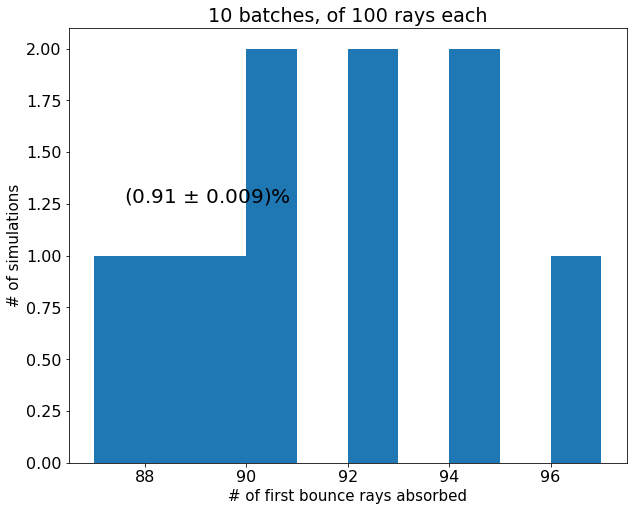

array([87., 88., 90., 90., 89., 92., 94., 97., 94., 92.])

In [11]:
Test_Efficiency(N[2]-winston_cone,N_iter=10,N_ray=100,N_proc=10,N_bounce=1,parallel=True,cones=False)